In [1]:
import os

directory = "../res/sprays"

match_ids = [
    match_id for match_id in os.listdir(directory) if not match_id.startswith(".")
]

match_ids

['93110',
 '93000',
 '93001',
 '93037',
 '93052',
 '92999',
 '92990',
 '92997',
 '93220',
 '93211',
 '93229',
 '92996',
 '92998',
 '93076',
 '93085',
 '93228',
 '93217',
 '93221',
 '93103',
 '93105',
 '93102',
 '93113',
 '93125',
 '93050',
 '93035',
 '93224',
 '93215',
 '93212',
 '93073',
 '93087',
 '93213',
 '93222',
 '92992',
 '93086',
 '93100',
 '93109',
 '93191',
 '93198']

In [2]:
# count up players

sprays_by_player_id = {}

for match_id in match_ids:
    match_directory = os.path.join(directory, match_id)
    map_ids = [map_id for map_id in os.listdir(match_directory) if map_id.isnumeric()]
    for map_id in map_ids:
        map_directory = os.path.join(match_directory, map_id)
        player_ids = [player_id for player_id in os.listdir(map_directory) if player_id.isnumeric()]
        for player_id in player_ids:
            player_directory = os.path.join(map_directory, player_id)
            csvs = [csv for csv in os.listdir(player_directory) if csv.endswith(".csv")]
            for csv in csvs:
                spray = f"{match_id}_{map_id}_{csv}"
                if player_id not in sprays_by_player_id:
                    sprays_by_player_id[player_id] = []
                sprays_by_player_id[player_id].append(spray)

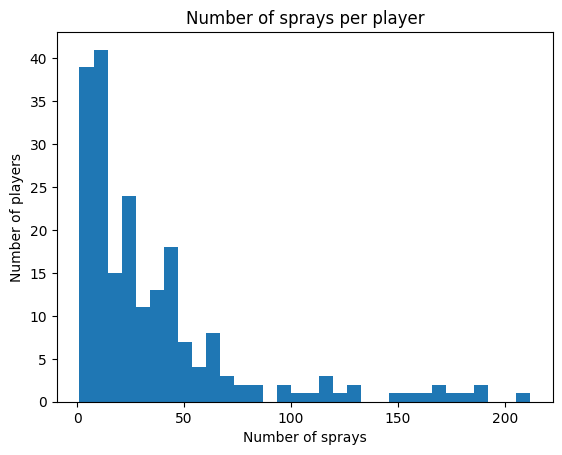

In [3]:
import matplotlib.pyplot as plt

spray_counts_by_player_id = {
    player_id: len(sprays)
    for player_id, sprays in sprays_by_player_id.items()
}

plt.hist(spray_counts_by_player_id.values(), bins=32)
plt.xlabel("Number of sprays")
plt.ylabel("Number of players")
plt.title("Number of sprays per player")
plt.show()

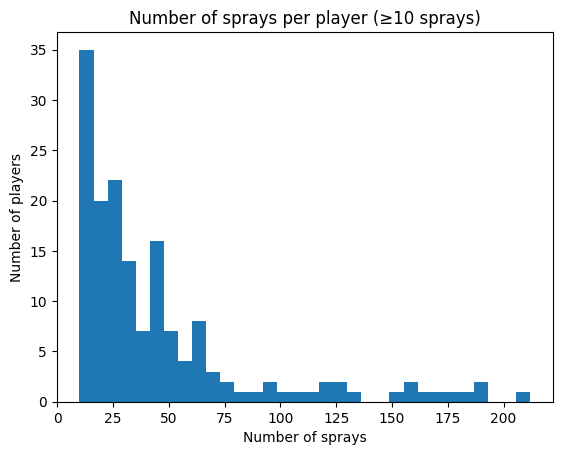

160 unique players


In [4]:
k = 10

filtered_spray_counts_by_player_id = {
    player_id: count
    for player_id, count in spray_counts_by_player_id.items()
    if count >= k
}

plt.hist(filtered_spray_counts_by_player_id.values(), bins=32)
plt.xlabel("Number of sprays")
plt.ylabel("Number of players")
plt.title(f"Number of sprays per player (≥{k} sprays)")
plt.show()

print(len(filtered_spray_counts_by_player_id.keys()), "unique players")

In [5]:
import numpy as np

# create a generator with a specific seed
rng = np.random.default_rng(seed=410)

# split player IDs into train/test sets
player_ids = list(filtered_spray_counts_by_player_id.keys())

# train split, 1 minus this value is test split
player_split = 0.8

player_ids_train = rng.choice(player_ids, size=int(len(player_ids) * player_split), replace=False)
player_ids_test = [player_id for player_id in player_ids if player_id not in player_ids_train]
print(len(player_ids_train), "unique players (train)")
print(len(player_ids_test), "unique players (test)")

128 unique players (train)
32 unique players (test)


In [6]:
import pandas as pd


def load_spray(player_id: str):
    player_sprays = sprays_by_player_id[player_id]
    player_spray = player_sprays[int(rng.random() * len(player_sprays))]
    match_id, map_id, csv = player_spray.split("_")
    path = os.path.join(directory, match_id, map_id, player_id, csv)
    data = pd.read_csv(path).to_numpy()
    return data


def load_sprays(player_id: str, n: int = 10):
    player_sprays = sprays_by_player_id[player_id]
    player_sprays = rng.choice(player_sprays, size=n, replace=False)
    data = []
    for player_spray in player_sprays:
        match_id, map_id, csv = player_spray.split("_")
        path = os.path.join(directory, match_id, map_id, player_id, csv)
        data.append(pd.read_csv(path).to_numpy())
    data = np.array(data)
    return data

In [7]:
X_train = []
y_train = []

n_train_samples = 16_000

for _ in range(n_train_samples):
    # 50/50 chance to select positive or negative class
    if rng.random() < 0.5:
        # positive class
        i = rng.choice(player_ids_train)
        spray1 = load_spray(i)
        spray2 = load_spray(i)
        y_train.append(1)
    else:
        # negative class
        i, j = rng.choice(player_ids_train, size=2, replace=False)
        spray1 = load_spray(i)
        spray2 = load_spray(j)
        y_train.append(0)
    pair = np.stack([spray1, spray2], axis=0)
    X_train.append(pair)

X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(16000, 2, 64, 2)
(16000,)


In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for batch in train_dataloader:
    print(batch[0].shape, batch[1].shape)
    break

torch.Size([32, 2, 64, 2]) torch.Size([32])


In [9]:
class PlayerIdentifier(torch.nn.Module):
    def __init__(self, hidden_size=16, num_layers: int = 3, bidirectional=True):
        super(PlayerIdentifier, self).__init__()
        self.lstm = torch.nn.LSTM(
            input_size=2,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(hidden_size * (2 if bidirectional else 1), 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1)
        )

    @property
    def total_parameters(self):
        total_params = 0
        for p in self.parameters():
            if p.requires_grad:
                total_params += p.numel()
        return total_params

    def forward(self, a, b):
        mean_a = torch.mean(a, dim=1, keepdim=True)
        mean_b = torch.mean(b, dim=1, keepdim=True)
        a = a - mean_a
        b = b - mean_b

        _, (h, c) = self.lstm(a)
        ca = c[-1]
        _, (h, c) = self.lstm(b)
        cb = c[-1]

        latent = torch.cat((ca, cb), dim=1)
        logits = self.linear(latent)
        return logits


model = PlayerIdentifier()
print(model.total_parameters, "trainable parameters")
for batch in train_dataloader:
    model(batch[0][:, 0], batch[0][:, 1])
    break

15905 trainable parameters


In [11]:
model = PlayerIdentifier(hidden_size=16, num_layers=4, bidirectional=True)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()
    epoch_loss = 0
    for x, y in train_dataloader:
        optimizer.zero_grad()
        logits = model(x[:, 0], x[:, 1]).squeeze()
        loss = loss_fn(logits, y.float())
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"loss: {epoch_loss / len(train_dataloader):.4f}")


for i, epoch in enumerate(range(10), start=1):
    print("epoch", i, "\t", end="")
    train()

epoch 1 	current epoch loss: 0.6933
epoch 2 	current epoch loss: 0.6929
epoch 3 	current epoch loss: 0.6883
epoch 4 	current epoch loss: 0.6865
epoch 5 	current epoch loss: 0.6844
epoch 6 	current epoch loss: 0.6833
epoch 7 	current epoch loss: 0.6823
epoch 8 	current epoch loss: 0.6815
epoch 9 	current epoch loss: 0.6811
epoch 10 	current epoch loss: 0.6802


[[4348 3685]
 [3218 4749]]
0.5982038897505615


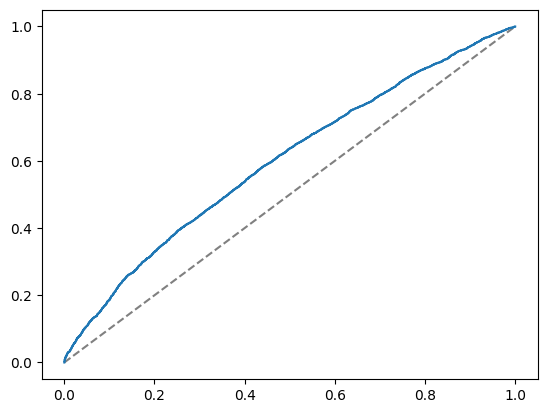

In [12]:
import sklearn
import matplotlib.pyplot as plt


def test(dataset):
    true, pred, scores = [], [], []
    model.eval()
    for x, y in DataLoader(dataset, batch_size=128):
        logits = model(x[:, 0], x[:, 1]).squeeze()
        probs = torch.sigmoid(logits)
        true.extend(y.tolist())
        pred.extend(torch.where(probs > 0.5, 1, 0).tolist())
        scores.extend(logits.tolist())

    cm = sklearn.metrics.confusion_matrix(true, pred)
    auc = sklearn.metrics.roc_auc_score(true, scores)
    print(cm)
    print(auc)

    fpr, tpr, thresholds = sklearn.metrics.roc_curve(true, scores)

    plt.plot(np.arange(0, 2), np.arange(0, 2), linestyle="--", color="gray")
    plt.plot(fpr, tpr)
    plt.show()


test(train_dataset)

In [13]:
X_test = []
y_test = []

n_test_samples = 4_000

for _ in range(n_test_samples):
    # 50/50 chance to select positive or negative class
    if rng.random() < 0.5:
        # positive class
        i = rng.choice(player_ids_test)
        spray1 = load_spray(i)
        spray2 = load_spray(i)
        y_test.append(1)
    else:
        # negative class
        i, j = rng.choice(player_ids_test, size=2, replace=False)
        spray1 = load_spray(i)
        spray2 = load_spray(j)
        y_test.append(0)
    pair = np.stack([spray1, spray2], axis=0)
    X_test.append(pair)

X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape)
print(y_test.shape)

test_dataset = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).float()
)

(4000, 2, 64, 2)
(4000,)


[[ 996  928]
 [ 853 1223]]
0.5621322189241265


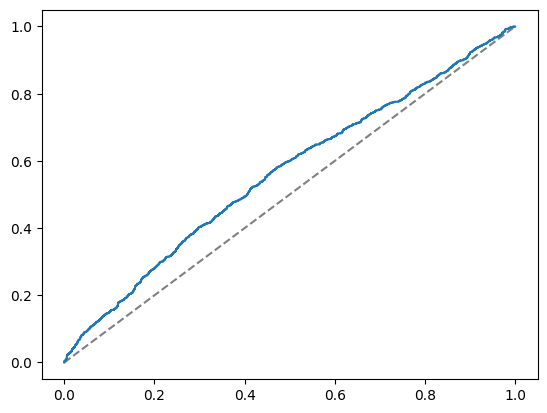

In [14]:
test(test_dataset)